# Alcanzando los objetivos de desarrollo sostenible. 
Un aporte desde el machine learning.

# Introducción

## Tabla de contenidos

# Importar las librerías


In [183]:
import pandas as pd

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from unidecode import unidecode

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
# Representación tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preparación de datos

## Datos

Los datos disponibles para este proyecto tal como aparecen en el enunciado de **Microproyecto2.pdf** son *"El conjunto de  datos forma parte del proyecto “OSDG Community Dataset”1 (OSDG-CD), en su 
versión 2023, que contiene un total de 40.067 textos, de los cuales 3000 provienen de fuentes relacionadas  con  las  Naciones  Unidas ... Los textos que serán utilizados en este proyecto han sido traducidos al español por herramientas 
como Deepl2. También se realizó una aumentación de textos a través del API de ChatGPT3."*, el cual está disponible como archivo Excel.

In [149]:
raw_data = pd.read_excel("Data\Train_textosODS.xlsx")

In [150]:
print(f"Cantidad de registros: {raw_data.shape[0]}, Cantidad de columnas: {raw_data.shape[1]}")
display(raw_data.head(5))
print("Valores nulos:")
raw_data.isna().sum()

Cantidad de registros: 9656, Cantidad de columnas: 2


,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5


Valores nulos:


textos    0
ODS       0
dtype: int64

Podemos observar la estructura de los datos siendo estos 9656 registros con 2 columnas:
* textos: El texto a analizar.
* ODS: Objetivo de Desarrollo Sostenible al que pertenece el texto (númerico).
De los cuales no se tienen valores faltantes, dada la estructurua de los datos, podremos usar modelos de clasificación para predecir a que ODS pertenece un texto dado que poseemos la etiqueta de cada texto.

In [151]:
raw_data["ODS"].value_counts().sort_index()

ODS
1      505
2      369
3      894
4     1025
5     1070
6      695
7      787
8      446
9      343
10     352
11     607
12     312
13     464
14     377
15     330
16    1080
Name: count, dtype: int64

Como vemos tenemos 16 clases a predecir, por lo que este problema es un problema de clasificación multiclase. Además para facilidad de uso, se transformará la columna ODS para numerar los objetivos de desarrollo sostenible comenzando en 0.

In [152]:
raw_data["ODS"] = raw_data["ODS"]-1

A continuación se muestra la cantidad de textos por ODS:


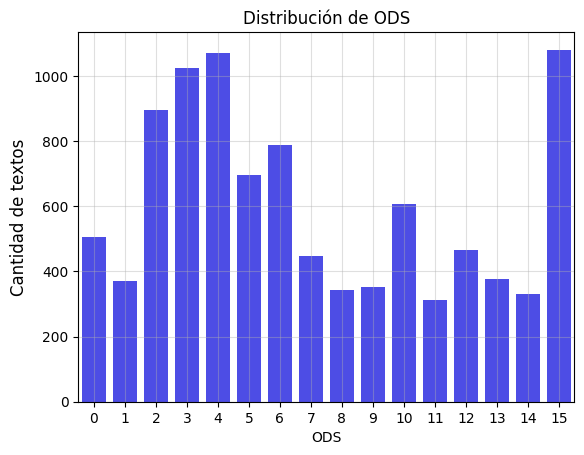

In [153]:
# sns barplot with the count of each category
sns.barplot(raw_data['ODS'].value_counts(),color='blue',alpha=0.8)
plt.title('Distribución de ODS')
plt.ylabel('Cantidad de textos', fontsize=12)
plt.grid(alpha=0.4)
plt.show()


Posteriormente se divide el conjunto de datos en dos partes, una para entrenamiento y otra para validación (val), con el fin de evaluar el rendimiento de los modelos, así mismo el conjunto de datos de entrenamiento nuevamente en particiones para entrenamiento (train) y prueba (test).

In [154]:
X_data, X_val, y_data, y_val = train_test_split(raw_data['textos'], raw_data['ODS'], test_size=0.2, random_state=100)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=100)

print(f"Dimensiones de validación (X, y): {X_val.shape}, {y_val.shape}")
print(f"Dimensiones de entrenamiento (X, y): {X_train.shape}, {y_train.shape}")
print(f"Dimensiones de test (X, y): {X_test.shape}, {y_test.shape}")


Dimensiones de validación (X, y): (1932,), (1932,)
Dimensiones de entrenamiento (X, y): (6179,), (6179,)
Dimensiones de test (X, y): (1545,), (1545,)


## Función de preprocesamiento

Para el preprocesamiento de los datos se utilizará la función **text_preprocess** que se encargará de realizar las siguientes tareas:
* Normalización de texto.
* Eliminación de carácteres especiales y dobles espacios.
* Tokenización.
* Eliminación de stopwords.
* Lematización.

In [155]:

# compilar los patrones a usar y definir los objetos necesarios previamente. (mejora de rendimiento)
pat = re.compile(r"[^a-z ]")
spaces = re.compile(r"\s{2,}")
tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('spanish'))

def text_preprocess(text):
    # Normalizar el texto
    norm_text = unidecode(text).lower()

    # solo se aceptan caracteres de la a-z y sin dobles espacios
    # Eliminar caracteres especiales
    clean_text = re.sub(pat, " ", norm_text)
    # Eliminar espacios duplicados
    spaces_text = re.sub(spaces, " ", clean_text)

    # tokenización
    tokens = tokenizer.tokenize(spaces_text.strip())

    # filtrado de stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming / Lematización
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

Usando la función anterior obtenemos el siguiente resultado:

In [156]:
print("texto original: \n", raw_data["textos"][0])
print("\n")
print("texto procesado: \n", text_preprocess(raw_data["textos"][0]))

texto original: 
 "Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formación de docentes, se consideran extensiones de los acuerdos establecidos por los gobiernos. Este marco de comprensión se ha vuelto cada vez más inadecuado.


texto procesado: 
 aprendizaj educacion consideran sinonimo escolarizacion formal organizacion auxiliar editorial educacion junta examinadora organizacion formacion docent consideran extension acuerdo establecido gobierno marco comprens vuelto cada vez ma inadecuado


## Representación de textos

Procedemos a representar los textos en una bolsa de palabras, para ello se utiliza la función **CountVectorizer** de la librería **sklearn**, la cual puede recibir como argumento nuestra función de preprocesamiento y posteriormente ajustar y transformar un conjunto de textos dado. La bolsa de palabras es una matriz que contiene la frecuencia de las palabras en los textos, en este caso se obtiene una matriz de 6179x22523, es decir, 6179 textos y 22523 palabras.

In [157]:
vectorizer = CountVectorizer(preprocessor=text_preprocess)
x_train = vectorizer.fit_transform(X_train)
count_vect_example = x_train[0].toarray()
x_train.shape

(6179, 22523)

Adicionlmente podemos combinar la representación anterior con la técnica de **TF-IDF** (Term Frequency-Inverse Document Frequency) que nos permite darle un peso a las palabras en función de su frecuencia en el texto y en el conjunto de textos, para ello se utiliza la función **TfidfVectorizer** de la librería **sklearn**.

In [158]:
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train)
tf_idf_example = x_train_tfidf[0].toarray()
x_train_tfidf.shape


(6179, 22523)

In [159]:
def show_representation( x_train, head=5, y_train=y_train):
    """
    Muestra la representación de los datos transformados por CountVectorizer o TF-IDF solo para las palabras relevantes (no cero)

    Parameters:
    x_train (sparse matrix): Matriz dispersa de datos transformados
    head (int): Cantidad de registros a mostrar
    y_train (pd.Series): Serie de datos objetivo

    Returns:
    None

    """

    data_transformed = pd.DataFrame(x_train[0:head].toarray(), columns=vectorizer.get_feature_names_out())
    data_transformed["ODS"] = y_train[0:head].values

    data_transformed = data_transformed.loc[:, (data_transformed != 0).any(axis=0)]
    display(data_transformed)


print("Ejemplo de representación de un texto en CountVectorizer y TF-IDF: \n")

print("CountVectorizer: \n")
show_representation(x_train, head=5)

print("TF-IDF: \n")
show_representation(x_train_tfidf, head=5)

Ejemplo de representación de un texto en CountVectorizer y TF-IDF: 

CountVectorizer: 



,abierto,adaptars,afiliado,ahora,alrededor,alto,america,argumento,atencion,aun,...,uso,valor,ve,ver,vision,vista,volvieron,vulner,vulnerabilidad,ODS
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,9
1,0,0,2,0,2,1,1,0,0,1,...,0,0,1,0,0,0,0,1,1,2
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,1,0,0,0,5
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2


TF-IDF: 



,abierto,adaptars,afiliado,ahora,alrededor,alto,america,argumento,atencion,aun,...,uso,valor,ve,ver,vision,vista,volvieron,vulner,vulnerabilidad,ODS
0,0.000000,0.00000,0.000000,0.108229,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.095259,0.000000,0.110596,0.00000,0.000000,0.185702,0.000000,0.000000,9
1,0.000000,0.00000,0.221634,0.000000,0.126654,0.05369,0.076299,0.0000,0.000000,0.059127,...,0.000000,0.000000,0.082904,0.000000,0.00000,0.000000,0.000000,0.076939,0.082661,2
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.1816,0.000000,0.000000,...,0.112756,0.000000,0.000000,0.000000,0.17267,0.172986,0.000000,0.000000,0.000000,5
3,0.158275,0.15697,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10
4,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.105004,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2


Tal como se observa en el ejemplo anterior, tomando las primeras filas y observando los valores de la bolsa de palabras y TF-IDF, se puede observar que la bolsa de palabras tiene conteos determinando la frecuencia de una palabra en el documento, mientras que TF-IDF tiene valores ponderados que indican la importancia de una palabra en el documento y en el corpus (Colección de documentos).

## Reducción de la dimensionalidad

Para evitar la conversión de la matriz dispersa (obtenida en la representación de textos anterior) en una matriz densa (lo que podría causar problemas de memoria RAM debido al tamaño resultante de la matriz densa) producto de usar **PCA** como reductor de dimensionalidad, se opta por usar **TruncatedSVD** el cual permite realizar la descomposición en valores singulares directamente en la matriz dispersa sin necesidad de centrar los datos, lo que lo hace más eficiente en términos de memoria y tiempo de computación.

In [160]:
tsvd = TruncatedSVD(n_components=100)

# Modelado

## Pipeline de preprocesamiento

Con lo mencionado hasta ahora, nuestro pipeline de preprocesamiento se compone de las siguientes etapas:
* **Preprocesamiento de texto:** Encargado de la limpieza y normalización de los textos (el cual está como parámetro en CountVectorizer).
* **Representación de textos:** Encargado de convertir los textos en una bolsa de palabras y TF-IDF, por ende pasar de una representación de texto a una representación numérica.
* **Reducción de la dimensionalidad:** Encargado de reducir la dimensionalidad de la matriz dispersa resultante de la representación de textos.
  


In [161]:
steps = [
    ('vectorizer', CountVectorizer(preprocessor=text_preprocess)),
    ('tfidf', TfidfTransformer()),
    ('tsvd', tsvd)]

preprocesamiento = Pipeline(steps)
preprocesamiento

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function text_preprocess at 0x0000020688458790>)),
                ('tfidf', TfidfTransformer()),
                ('tsvd', TruncatedSVD(n_components=100))])

## Prueba de modelos de clasificación


In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


# Diccionario de modelos a utilizar
models = {
    'Random_Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier()
}



# Diccionario de parámetros para cada modelo
model_params = {
    'Random_Forest': {
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [None, 10, 20],
        
    },
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
    },
    'XGBoost': {
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [None, 10, 20],
     
    }
    }


# Diccionario de resultados para cada modelo
results = {}

# Iterar sobre cada modelo, realiza el preprocesamiento, y el modelado para cada combinación dentro de la búsqueda de hiperparámetros.
for model_name, model in models.items():
    
    print(f"Modelo: {model_name}")
    
    pipeline = Pipeline([
        ('preprocessing', preprocesamiento), # Usamos el pipeline de preprocesamiento definido anteriormente
        ('model', model)
    ])

    # Usamos los parámetros definidos para cada modelo
    params = model_params[model_name]

    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='accuracy',n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train) 

    # Guardar los resultados
    results[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_accuracy': accuracy_score(y_test, grid_search.predict(X_test))
    }



Modelo: Random_Forest
Fitting 5 folds for each of 9 candidates, totalling 45 fits


Modelo: SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Modelo: XGBoost
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [173]:
best_models = {}

for model_name, result in results.items():
    print(f"{model_name}:")

    best_models[model_name] = result['best_estimator']
    
    print(f"Best parameters: {result['best_params']}")
    print(f"Best cross-validation score: {result['best_score']}")
    print(f"Test accuracy: {result['test_accuracy']}")
    print("\n")

Random_Forest:
Best parameters: {'model__max_depth': 20, 'model__n_estimators': 100}
Best cross-validation score: 0.817931292008962
Test accuracy: 0.8064724919093851


SVM:
Best parameters: {'model__C': 1, 'model__kernel': 'rbf'}
Best cross-validation score: 0.8600093025693434
Test accuracy: 0.8524271844660194


XGBoost:
Best parameters: {'model__max_depth': None, 'model__n_estimators': 100}
Best cross-validation score: 0.8316880887805773
Test accuracy: 0.827831715210356




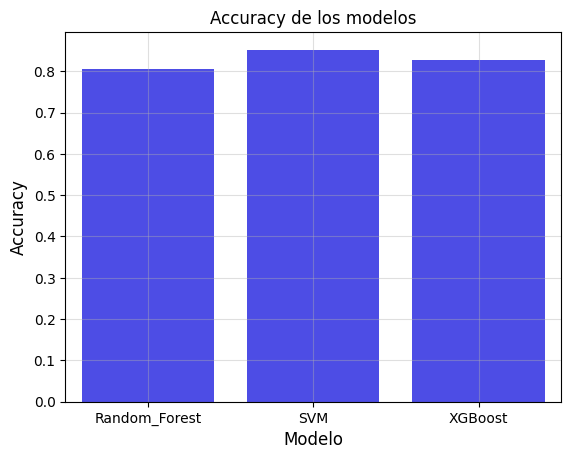

In [174]:
# graficamos los resultados
df_results = pd.DataFrame(results).T
df_results = df_results.reset_index()
df_results = df_results.rename(columns={'index': 'Modelo'})
df_results

sns.barplot(data=df_results, x='Modelo', y='test_accuracy', color='blue', alpha=0.8)
plt.title('Accuracy de los modelos')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.grid(alpha=0.4)
plt.show()



Modelo: Random_Forest


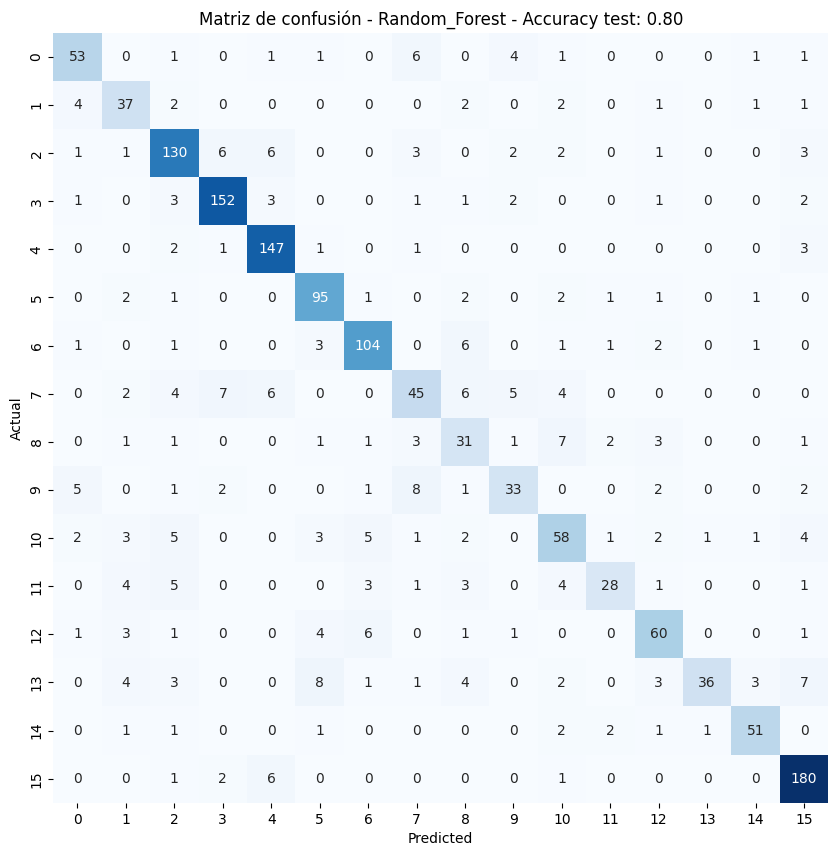

Modelo: SVM


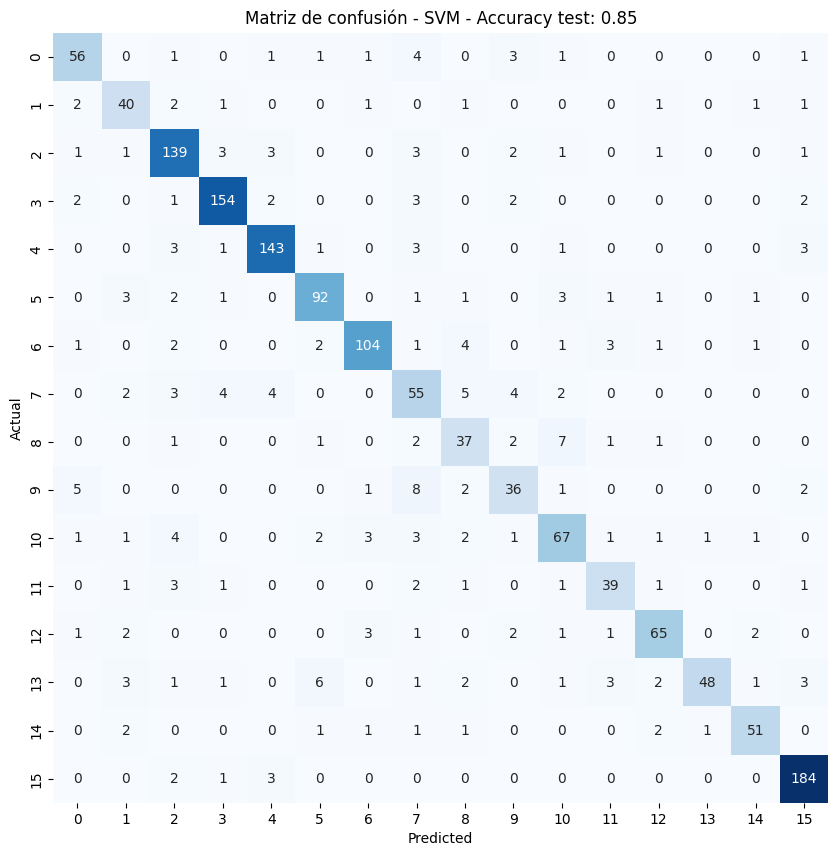

Modelo: XGBoost


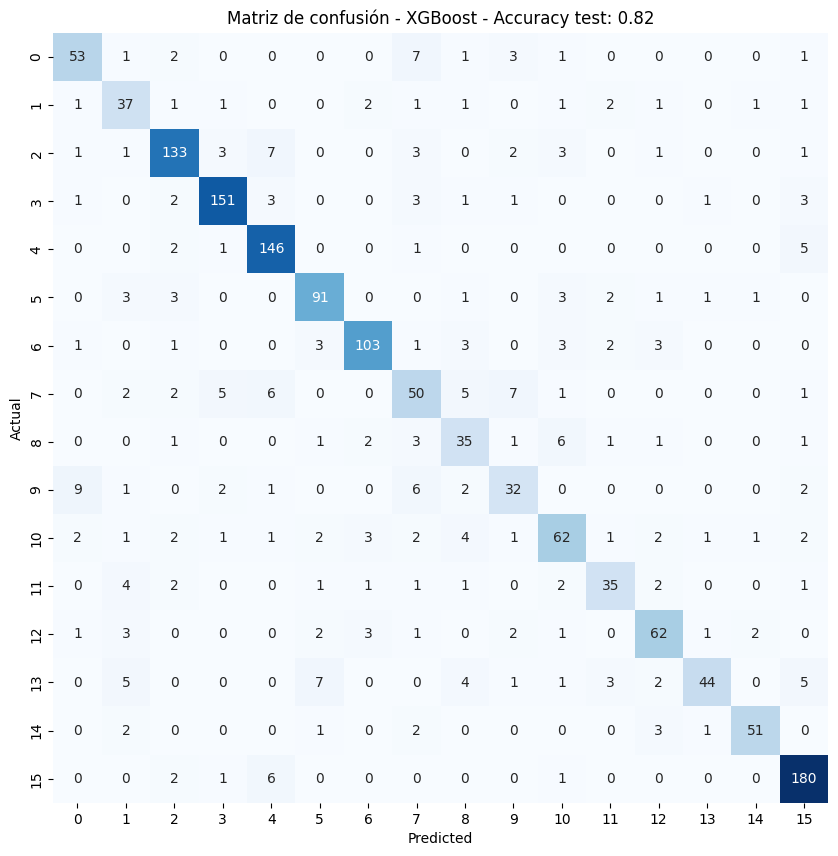

In [182]:

for model in best_models.keys():
    print(f"Modelo: {model}")
    best_models[model].fit(X_train, y_train)

    test_accuracy = best_models[model].score(X_test, y_test)

    y_pred = best_models[model].predict(X_test)

    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de confusión - {model} - Accuracy test: {test_accuracy:.2f}')
    plt.xlabel('Predicted')

    plt.ylabel('Actual')
    plt.show()

In [228]:
df_report = pd.DataFrame()
df_salida = pd.DataFrame()

for model in best_models.keys():

    best_models[model].fit(X_train, y_train)

    y_pred = best_models[model].predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Modelo: {model}")
    print(classification_report(y_test, y_pred))


    df_report = pd.DataFrame(report).T
    df_report["métrica"] = df_report.index
    df_report = df_report.reset_index(drop=True)
    df_report["modelo"] = model
    df_salida = pd.concat([df_salida, df_report])



Modelo: Random_Forest
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.61      0.72      0.66        50
           2       0.80      0.85      0.82       155
           3       0.90      0.92      0.91       166
           4       0.86      0.95      0.90       155
           5       0.80      0.89      0.84       106
           6       0.85      0.87      0.86       120
           7       0.65      0.61      0.63        79
           8       0.57      0.60      0.58        52
           9       0.74      0.56      0.64        55
          10       0.62      0.65      0.63        88
          11       0.84      0.54      0.66        50
          12       0.82      0.77      0.79        78
          13       0.91      0.56      0.69        72
          14       0.89      0.83      0.86        60
          15       0.86      0.94      0.90       190

    accuracy                           0.80      1545
   m

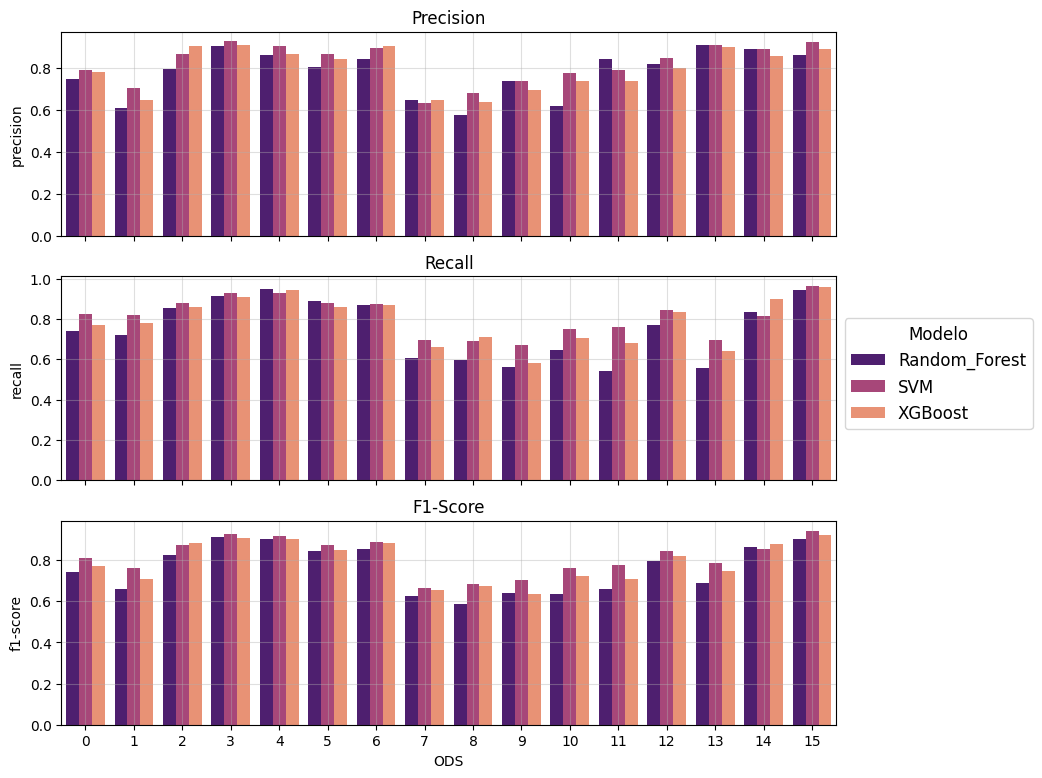

In [229]:
df = df_salida.loc[~df_salida["métrica"].isin(["accuracy", "macro avg", "weighted avg"])]

# Gráficar los resultados del reporte de clasificación
fig, ax = plt.subplots(3, 1, figsize=(10, 9),sharex=True)
sns.barplot(data=df, x='métrica', y='precision', hue='modelo', ax=ax[0], palette='magma')
sns.barplot(data=df, x='métrica', y='recall', hue='modelo', ax=ax[1], palette='magma')
sns.barplot(data=df, x='métrica', y='f1-score', hue='modelo', ax=ax[2], palette='magma')

ax[0].set_title('Precision')
ax[0].grid(alpha=0.4)
ax[1].set_title('Recall')
ax[1].grid(alpha=0.4)
ax[2].set_title('F1-Score')
ax[2].grid(alpha=0.4)
ax[2].set_xlabel('ODS')


# Eliminar las leyendas de los subplots
for a in ax:
    a.get_legend().remove()

# definir leyenda
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), title="Modelo", title_fontsize='large', fontsize='large')


plt.show()



# Predicción con el mejor modelo

Dados los resultados anteriores el mejor modelo es el SMV con un accuracy de 0.85 en el conjunto de test, por lo que se procede a realizar la predicción de los textos de validación y se obtiene el siguiente resultado:

In [230]:
best_models["SVM"]

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('vectorizer',
                                  CountVectorizer(preprocessor=<function text_preprocess at 0x0000020688458790>)),
                                 ('tfidf', TfidfTransformer()),
                                 ('tsvd', TruncatedSVD(n_components=100))])),
                ('model', SVC(C=1))])

In [231]:
best_models["SVM"].fit(X_train, y_train)

y_pred = best_models["SVM"].predict(X_val)

report = classification_report(y_val, y_pred, output_dict=True)
print(f"Modelo: SVM")
print(classification_report(y_val, y_pred))


Modelo: SVM
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       107
           1       0.84      0.86      0.85        65
           2       0.87      0.90      0.89       184
           3       0.94      0.95      0.94       196
           4       0.91      0.94      0.93       216
           5       0.91      0.93      0.92       145
           6       0.88      0.87      0.88       166
           7       0.62      0.64      0.63        80
           8       0.69      0.70      0.70        81
           9       0.71      0.60      0.65        70
          10       0.81      0.83      0.82       115
          11       0.88      0.77      0.82        66
          12       0.88      0.87      0.88        95
          13       0.95      0.85      0.90        67
          14       0.93      0.86      0.90        65
          15       0.95      0.95      0.95       214

    accuracy                           0.87      1932
   macro avg  

# Conclusiones

___

# Test Fine tunning usando BERT

En esta sección se realizará el fine tunning de un modelo BERT para la clasificación de textos, para ello se utilizará la librería **transformers** de Hugging Face, la cual nos permite cargar un modelo pre-entrenado y realizar el fine tunning del mismo.

## Tokenización

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_data_train = tokenizer(dataset_train["sentence"], return_tensors="np", padding=True)

labels_train = tf.keras.utils.to_categorical(np.array(dataset_train["label"]))

## Modelo


In [ ]:

from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

# Definimos y cargamos el modelo
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")

Podemos ver la arquitectura del modelo actual.

In [ ]:
model.summary()

Obeservamos la última capa del modelo, la cual es una capa lineal con 2 neuronas.

In [ ]:
model.layers[-1].get_config()

Ajustamos las neuronas de salida a 17, ya que son la cantidad de clases que tenemos.

In [ ]:
TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=17)

### Calentamiento

AJUSTAR LA MÉTRICA DE EVALUACIÓN, NO TENEMOS SOLO  2 CLASES, SINO 17.

In [ ]:
# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=5e-6),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True))

# Congelamos las capas del modelo BERT
for i in range(len(model.layers)-1):
  model.layers[i].trainable = False

model.summary()

In [ ]:
#Definimos un callback
stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=5,
                mode="min",
                restore_best_weights=True
            )
# Entrenamos
history = model.fit(dict(tokenized_data_train),
                    labels_train,
                    epochs = 10,            # Entrenamos por pocas epochs
                    batch_size=32,
                    validation_split = 0.2, # Usamos el 20% del dataset como conjunto de validación
                    callbacks=[stopping])

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.plot(history.history["loss"])
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.style.use("ggplot")
plt.plot(history.history["val_loss"])
plt.title("Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Fine Tunning

Ahora vamos a entrenar todo el modelo ajustándolo un poco más a partir de los pesos obtenidos con el calentamiento. Volvemos entrenables las capas que estaban congeladas:

In [ ]:
for i in range(len(model.layers)-1):
  model.layers[i].trainable = True

Y compilamos de nuevo usando esta vez una tasa de aprendizaje mucho más baja (`1e-9`):

In [ ]:
vectorizer = CountVectorizer(preprocessor=text_preprocess)
x_train = vectorizer.fit_transform(X_train)
count_vect_example = x_train[0].toarray()
x_train.shape

(6179, 22523)

En este momento tenemos 108'311.810 parámetros para entrenar. Como todo el tiempo hemos manipulado el mismo modelo `model`, no necesitamos guardar los pesos del calentamiento y volverlos a cargar; de eso se ha encargado `tf.keras.callbacks.EarlyStopping` ya que definimos `restore_best_weights=True`. A continuación de nuevo usamos un `EarlyStopping` y entrenamos con la función `fit()`:

In [ ]:
#Definimos un callback
stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=5,
                mode="min",
                restore_best_weights=True
            )
# Entrenamos
history = model.fit(dict(tokenized_data_train),
                    labels_train,
                    epochs = 50,
                    batch_size=32,
                    validation_split = 0.2, # Usamos el 20% del dataset como conjunto de validación
                    callbacks=[stopping])

### Evaluación

In [ ]:
dataset_test = dataset["validation"] # Cargamos la partición de desarrollo

tokenized_data_test = tokenizer(dataset_test["sentence"], return_tensors="np", padding=True)
labels_test = np.array(dataset_test["label"])

Usamos `.predict` para hacer inferencia :

In [ ]:
predictions = model.predict(dict(tokenized_data_test))

Y recordemos que estas predicciones necesitan ser post-procesadas por una función _softmax_ :

In [ ]:
predictions = tf.math.softmax(predictions.logits)

Ya con esto, podemos usar cualquier métrica para medir el desempeño:

In [ ]:
from sklearn.metrics import *

print(classification_report(labels_test, np.argmax(predictions, axis=-1)))